# Download of the Dataset

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
cwd = '/content'
zip_url = 'https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip'
zip_path = '/content/human+activity+recognition+using+smartphones.zip'
data_set_name = 'UCI HAR Dataset'
data_set_zip_path = os.path.join(cwd, f'{data_set_name}.zip')
data_set_path = os.path.join(cwd,data_set_name)
# Downloads data if neccesary
if not os.path.exists(data_set_path):
  try:
    if not os.path.exists(zip_path):
      # Download the .zip file
      !wget --no-check-certificate -O {zip_path} {zip_url}

    if not os.path.exists(os.path.join(cwd,f'{data_set_name}.zip')):
      # Unzip the file
      !unzip {zip_path} "{data_set_name}.zip" -d {cwd}

    # Unzip the second zip
    !unzip "{data_set_zip_path}" "{data_set_name}/*" -d "{cwd}"
  except Exception as e:
    print(f"An error occured {str(e)}")
  else:
    # Deletes remaining zip archives
    !rm {zip_path} "{data_set_zip_path}"

--2023-11-14 00:17:51--  https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/content/human+activity+recognition+using+smartphones.zip’

/content/human+acti     [         <=>        ]  58.18M  32.6MB/s    in 1.8s    

2023-11-14 00:17:53 (32.6 MB/s) - ‘/content/human+activity+recognition+using+smartphones.zip’ saved [61005872]

Archive:  /content/human+activity+recognition+using+smartphones.zip
 extracting: /content/UCI HAR Dataset.zip  
Archive:  /content/UCI HAR Dataset.zip
   creating: /content/UCI HAR Dataset/
  inflating: /content/UCI HAR Dataset/.DS_Store  
  inflating: /content/UCI HAR Dataset/activity_labels.txt  
  inflating: /content/UCI HAR Dataset/features.txt  
  inflating: /content/UCI HAR Datas

# Data Exploration

In [3]:
# Paths to the data
train_time_series_path = os.path.join(data_set_path, 'train', 'Inertial Signals')
test_time_series_path = os.path.join(data_set_path, 'test', 'Inertial Signals')

# Paths to the time series
train_labels_path = os.path.join(data_set_path, 'train', 'y_train.txt')
test_labels_path = os.path.join(data_set_path, 'test', 'y_test.txt')

time_series_test = pd.read_csv(os.path.join(train_time_series_path,'body_acc_x_train.txt'), sep='\s+')
time_series_test.shape # Testing the shape of the dataset

(7351, 128)

In [4]:
# Number of samples, time steps, and features
train_n_samples, test_n_samples, n_time_steps, n_features, n_classes = 7352, 2947, 128, 9, 6

# Name of the features
feature_names = [
  'body_acc_x',
  'body_acc_y',
  'body_acc_z',
  'body_gyro_x',
  'body_gyro_y',
  'body_gyro_z',
  'total_acc_x',
  'total_acc_y',
  'total_acc_z'
]

## Processing Data

In [5]:
# Function that returns the required Dataframes
def format_data_cnn_lstm(n_samples: int, n_time_steps: int, n_features: int, n_classes: int,  feature_names: list[str], labels_path: str, time_series_path: str, set_type: str = 'train') -> tuple[np.ndarray, np.ndarray] :
  import numpy as np
  import pandas as pd
  import tensorflow.keras.utils as utils
  import os
  # Initialize an empty array for the features
  features = np.zeros((n_samples, n_time_steps, n_features))
  # Loops thorugh the files of the features
  for index, feature in enumerate(feature_names):
    file_path = os.path.join(time_series_path, f'{feature}_{set_type}.txt')
    feature_matrix = pd.read_csv(file_path, sep='\s+', header=None).values
    features[:, :, index] = feature_matrix

  # Loads the labels
  labels = pd.read_csv(labels_path, sep='\s+', header=None).values.flatten() - 1
  labels = utils.to_categorical(labels, num_classes=n_classes)

  return features, labels

train_data, train_labels = format_data_cnn_lstm(
    n_samples=train_n_samples,
    n_time_steps=n_time_steps,
    n_features=n_features,
    n_classes=n_classes,
    feature_names=feature_names,
    labels_path=train_labels_path,
    time_series_path=train_time_series_path
)

test_data, test_labels = format_data_cnn_lstm(
    n_samples=test_n_samples,
    n_time_steps=n_time_steps,
    n_features=n_features,
    n_classes=n_classes,
    feature_names=feature_names,
    labels_path=test_labels_path,
    time_series_path=test_time_series_path,
    set_type='test'
)

# Compare predicted Classes to the original class labels (which need to be in 1 to 6 format)
original_classes = np.argmax(test_labels, axis=1) + 1

In [6]:
train_data.shape

(7352, 128, 9)

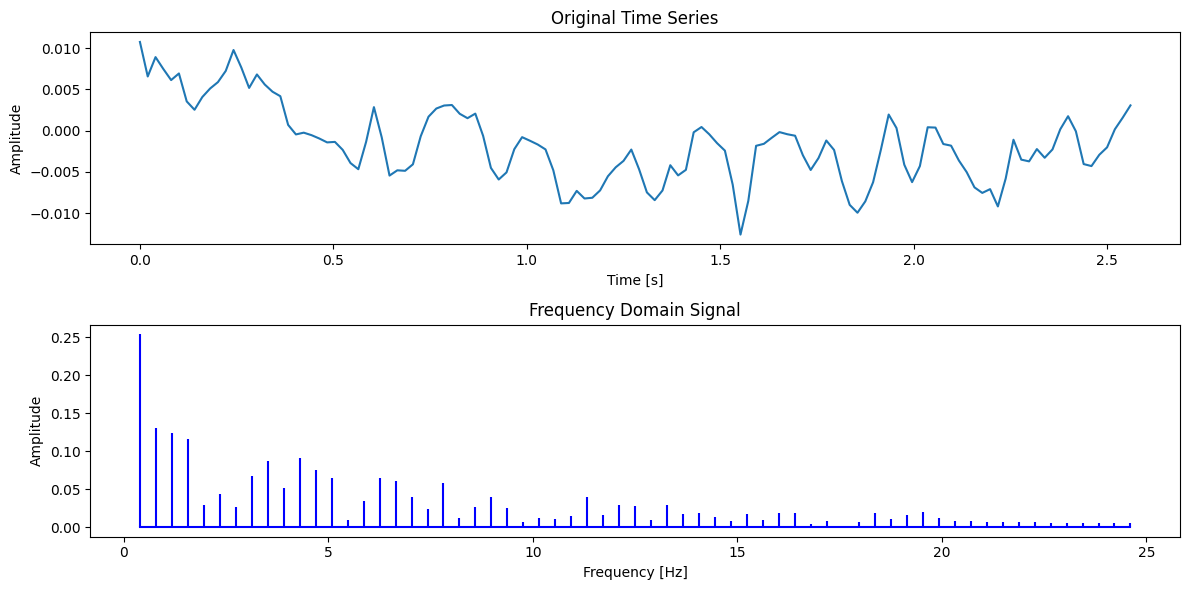

In [7]:
# Exploring conversion to frequency domain
import numpy as np
import matplotlib.pyplot as plt
# According to documentation of the dataset each window is 2.56s long
t = np.linspace(0.0, 2.56, 128)

# Apply Fast Fourier Transform to one time series
fft_signal = np.fft.fft(train_data[0,:,1])
fft_freq = np.fft.fftfreq(t.size, d=2.56/128)

# Only take the positive half of the frequencies and corresponding FFT values
positive_frequencies = fft_freq > 0
fft_signal = fft_signal[positive_frequencies]
fft_freq = fft_freq[positive_frequencies]

# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, train_data[0,:,1])
plt.title('Original Time Series')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the FFT of the signal
plt.subplot(2, 1, 2)
plt.stem(fft_freq, np.abs(fft_signal), 'b', markerfmt=" ", basefmt="-b")
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.tight_layout()

plt.show()

In [8]:
train_data_fft = np.abs(np.fft.rfft(train_data, axis=1))
test_data_fft = np.abs(np.fft.rfft(test_data, axis=1))

In [9]:
print(train_data_fft.shape)
# Shape of the transform
n_frequency_steps = train_data_fft.shape[1]
sample_spacing = 2.56 / 128

(7352, 65, 9)


## Defining Metrics

In [10]:
def print_metrics(predicted_classes: np.ndarray[int], original_classes: np.ndarray[int]) -> None:
  from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
  # Accuracy
  accuracy = accuracy_score(original_classes, predicted_classes)
  print(f'Accuracy: {accuracy:.2f}')

  # Confusion matrix
  conf_matrix = confusion_matrix(original_classes, predicted_classes)
  print(f'Confusion Matrix:\n{conf_matrix}')

  # Precision, recall, and F1 score for each class
  precision = [f'{class_precision:.2f}' for class_precision in precision_score(original_classes, predicted_classes, average=None, zero_division=0)]
  recall = [f'{class_recall:.2f}' for class_recall in recall_score(original_classes, predicted_classes, average=None, zero_division=0)]
  f1 = [f'{class_f1:.2f}' for class_f1 in f1_score(original_classes, predicted_classes, average=None, zero_division=0)]

  print(f'Precision per class: {", ".join(precision)}')
  print(f'Recall per class: {", ".join(recall)}')
  print(f'F1 Score per class: {", ".join(f1)}')

  # Single precision, recall and f1 score
  precision_macro = precision_score(original_classes, predicted_classes, average='macro', zero_division=0)
  recall_macro = recall_score(original_classes, predicted_classes, average='macro', zero_division=0)
  f1_macro = f1_score(original_classes, predicted_classes, average='macro', zero_division=0)

  print(f'Macro Precision: {precision_macro:.2f}')
  print(f'Macro Recall: {recall_macro:.2f}')
  print(f'Macro F1 Score: {f1_macro:.2f}')

In [11]:
def plot_accuracy_per_epoch(model_history) -> None:
  import matplotlib.pyplot as plt
  import tensorflow as tf

  # Extracting accuracies
  train_acc = model_history.history['accuracy']
  test_acc = model_history.history['val_accuracy']
  epochs = range(1, len(train_acc) + 1)

  # Plotting
  plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
  plt.plot(epochs, test_acc, 'ro-', label='Testing Accuracy')
  plt.title('Training and Testing Accuracy per Epoch')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

# CNN+LSTM

## Creating the Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# Model Definition
model = Sequential([
    # Convolutional layer
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_frequency_steps, n_features)),
    MaxPooling1D(pool_size=2),
    # LSTM layer
    LSTM(32),
    # Fully connected layer
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Model compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 32)            608       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 10,182
Trainable params: 10,182
Non-trainable params: 0
____________________________________________________

## Testing the Model

In [13]:
# Model training
history = model.fit(train_data_fft, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Predictions with test data
predictions = model.predict(test_data_fft)

# Class with highest probability
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes += 1

Epoch 1/10
184/184 [==============================] - 10s 39ms/step - loss: 1.0855 - accuracy: 0.4873 - val_loss: 0.6056 - val_accuracy: 0.6689
Epoch 2/10
184/184 [==============================] - 10s 57ms/step - loss: 0.4987 - accuracy: 0.7392 - val_loss: 0.4141 - val_accuracy: 0.7804
Epoch 3/10
184/184 [==============================] - 8s 43ms/step - loss: 0.3614 - accuracy: 0.8235 - val_loss: 0.3823 - val_accuracy: 0.8266
Epoch 4/10
184/184 [==============================] - 5s 29ms/step - loss: 0.2930 - accuracy: 0.8679 - val_loss: 0.3373 - val_accuracy: 0.8695
Epoch 5/10
184/184 [==============================] - 6s 35ms/step - loss: 0.2672 - accuracy: 0.8851 - val_loss: 0.2515 - val_accuracy: 0.8810
Epoch 6/10
184/184 [==============================] - 4s 22ms/step - loss: 0.2042 - accuracy: 0.9131 - val_loss: 0.2182 - val_accuracy: 0.9300
Epoch 7/10
184/184 [==============================] - 4s 22ms/step - loss: 0.2072 - accuracy: 0.9160 - val_loss: 0.2227 - val_accuracy: 0.91

In [14]:
print_metrics(predicted_classes, original_classes)

Accuracy: 0.91
Confusion Matrix:
[[445   5  46   0   0   0]
 [ 21 433  17   0   0   0]
 [ 34  21 365   0   0   0]
 [  0   0   0 407  83   1]
 [  0   9   2  37 484   0]
 [  0   0   0   0   0 537]]
Precision per class: 0.89, 0.93, 0.85, 0.92, 0.85, 1.00
Recall per class: 0.90, 0.92, 0.87, 0.83, 0.91, 1.00
F1 Score per class: 0.89, 0.92, 0.86, 0.87, 0.88, 1.00
Macro Precision: 0.91
Macro Recall: 0.90
Macro F1 Score: 0.90


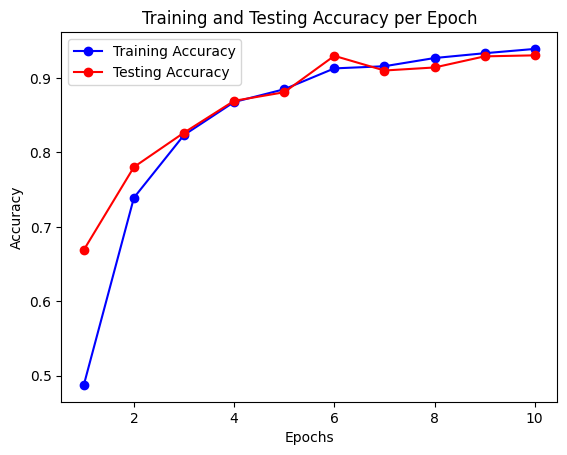

In [15]:
plot_accuracy_per_epoch(history)

# CNN+LSTM Improved

## Creating the Model

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout

# Model Definition
cnn_model = Sequential([
    # Convolutional layer
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_frequency_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # LSTM layer
    LSTM(64),
    # Fully connected layer
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

# Model compilation
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 63, 64)            1792      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 31, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 29, 128)           24704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 128)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)               

## Testing the Model

In [17]:
# Model training
cnn_history = cnn_model.fit(train_data_fft, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Predictions with test data
cnn_predictions = cnn_model.predict(test_data_fft)

# Class with highest probability
cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)
cnn_predicted_classes += 1

Epoch 1/10
184/184 [==============================] - 9s 28ms/step - loss: 0.8257 - accuracy: 0.6212 - val_loss: 0.3646 - val_accuracy: 0.8593
Epoch 2/10
184/184 [==============================] - 5s 26ms/step - loss: 0.3806 - accuracy: 0.8004 - val_loss: 0.3243 - val_accuracy: 0.8035
Epoch 3/10
184/184 [==============================] - 8s 45ms/step - loss: 0.3316 - accuracy: 0.8230 - val_loss: 0.2493 - val_accuracy: 0.8654
Epoch 4/10
184/184 [==============================] - 6s 32ms/step - loss: 0.2970 - accuracy: 0.8172 - val_loss: 0.2700 - val_accuracy: 0.8192
Epoch 5/10
184/184 [==============================] - 5s 27ms/step - loss: 0.2797 - accuracy: 0.8245 - val_loss: 0.2244 - val_accuracy: 0.8939
Epoch 6/10
184/184 [==============================] - 8s 43ms/step - loss: 0.2697 - accuracy: 0.8476 - val_loss: 0.2313 - val_accuracy: 0.8613
Epoch 7/10
184/184 [==============================] - 5s 27ms/step - loss: 0.2596 - accuracy: 0.8502 - val_loss: 0.2583 - val_accuracy: 0.8559

In [18]:
print_metrics(cnn_predicted_classes, original_classes)

Accuracy: 0.92
Confusion Matrix:
[[478   2  16   0   0   0]
 [  2 466   3   0   0   0]
 [  2  21 397   0   0   0]
 [  0   0   0 400  90   1]
 [  2   0   0  97 433   0]
 [  0   0   0   0   0 537]]
Precision per class: 0.99, 0.95, 0.95, 0.80, 0.83, 1.00
Recall per class: 0.96, 0.99, 0.95, 0.81, 0.81, 1.00
F1 Score per class: 0.98, 0.97, 0.95, 0.81, 0.82, 1.00
Macro Precision: 0.92
Macro Recall: 0.92
Macro F1 Score: 0.92


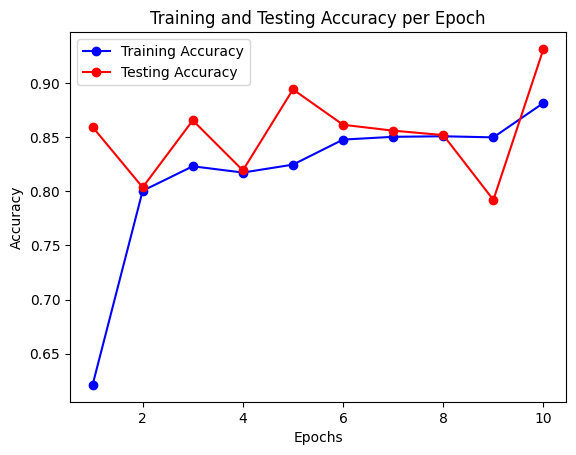

In [19]:
plot_accuracy_per_epoch(cnn_history)

# GRU

## Creating Model

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Model Definition
gru_model = Sequential([
    # GRU layer
    GRU(128, input_shape=(n_frequency_steps, n_features), return_sequences=True),
    Dropout(0.5),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    # Fully connected layer
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Model compilation
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 65, 128)           53376     
                                                                 
 dropout_1 (Dropout)         (None, 65, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 95,174
Trainable params: 95,174
Non-trai

## Testing Model

In [21]:
# Model training
gru_history = gru_model.fit(train_data_fft, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Predictions with test data
gru_predictions = gru_model.predict(test_data_fft)

# Class with highest probability
gru_predicted_classes = np.argmax(gru_predictions, axis=1)
gru_predicted_classes += 1

Epoch 1/10
184/184 [==============================] - 35s 156ms/step - loss: 1.2072 - accuracy: 0.3605 - val_loss: 0.9723 - val_accuracy: 0.4568
Epoch 2/10
184/184 [==============================] - 30s 163ms/step - loss: 0.8546 - accuracy: 0.5360 - val_loss: 0.7460 - val_accuracy: 0.5948
Epoch 3/10
184/184 [==============================] - 26s 143ms/step - loss: 0.6889 - accuracy: 0.6230 - val_loss: 0.6987 - val_accuracy: 0.5928
Epoch 4/10
184/184 [==============================] - 31s 167ms/step - loss: 0.6471 - accuracy: 0.6269 - val_loss: 0.7360 - val_accuracy: 0.6003
Epoch 5/10
184/184 [==============================] - 26s 144ms/step - loss: 0.6397 - accuracy: 0.6322 - val_loss: 0.7860 - val_accuracy: 0.5683
Epoch 6/10
184/184 [==============================] - 31s 169ms/step - loss: 0.6438 - accuracy: 0.6353 - val_loss: 0.7442 - val_accuracy: 0.6037
Epoch 7/10
184/184 [==============================] - 27s 145ms/step - loss: 0.6233 - accuracy: 0.6400 - val_loss: 0.6751 - val_ac

In [22]:
print_metrics(gru_predicted_classes, original_classes)

Accuracy: 0.72
Confusion Matrix:
[[310 100  86   0   0   0]
 [  0 441  30   0   0   0]
 [  1  22 397   0   0   0]
 [  0   1   0   0 490   0]
 [  0   0   0   0 532   0]
 [  0   1   0   1 104 431]]
Precision per class: 1.00, 0.78, 0.77, 0.00, 0.47, 1.00
Recall per class: 0.62, 0.94, 0.95, 0.00, 1.00, 0.80
F1 Score per class: 0.77, 0.85, 0.85, 0.00, 0.64, 0.89
Macro Precision: 0.67
Macro Recall: 0.72
Macro F1 Score: 0.67


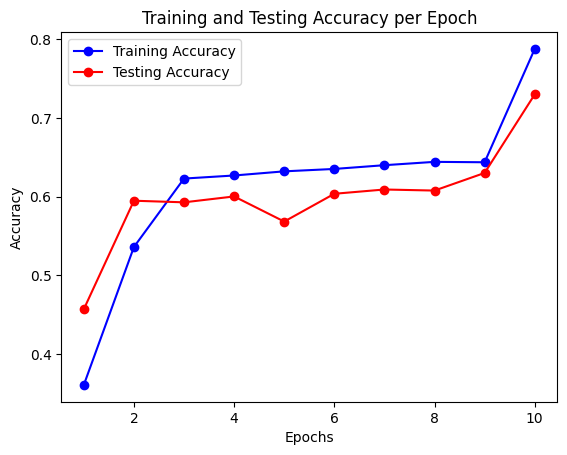

In [23]:
plot_accuracy_per_epoch(gru_history)

# CNN-GRU

## Creating Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, Flatten

# Model Definition
cnn_gru_model = Sequential([
    # Convolutional layer
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_frequency_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # GRU layer
    GRU(64, return_sequences=True),
    Dropout(0.5),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    # Fully connected layer
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Model compilation
cnn_gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
cnn_gru_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 63, 64)            1792      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 31, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 29, 128)           24704     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 14, 128)          0         
 1D)                                                             
                                                                 
 gru_2 (GRU)                 (None, 14, 64)            37248     
                                                                 
 dropout_3 (Dropout)         (None, 14, 64)           

## Testing Model

In [25]:
# Model training
cnn_gru_history = cnn_gru_model.fit(train_data_fft, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Predictions with test data
cnn_gru_predictions = cnn_gru_model.predict(test_data_fft)

# Class with highest probability
cnn_gru_predicted_classes = np.argmax(cnn_gru_predictions, axis=1)
cnn_gru_predicted_classes += 1

Epoch 1/10
184/184 [==============================] - 17s 59ms/step - loss: 0.9161 - accuracy: 0.5361 - val_loss: 0.4901 - val_accuracy: 0.7424
Epoch 2/10
184/184 [==============================] - 8s 42ms/step - loss: 0.4093 - accuracy: 0.7619 - val_loss: 0.3246 - val_accuracy: 0.7974
Epoch 3/10
184/184 [==============================] - 11s 57ms/step - loss: 0.3023 - accuracy: 0.8034 - val_loss: 0.4168 - val_accuracy: 0.8090
Epoch 4/10
184/184 [==============================] - 7s 39ms/step - loss: 0.2899 - accuracy: 0.8223 - val_loss: 0.2315 - val_accuracy: 0.8736
Epoch 5/10
184/184 [==============================] - 11s 62ms/step - loss: 0.2651 - accuracy: 0.8471 - val_loss: 0.2436 - val_accuracy: 0.8858
Epoch 6/10
184/184 [==============================] - 7s 38ms/step - loss: 0.2579 - accuracy: 0.8628 - val_loss: 0.2315 - val_accuracy: 0.8545
Epoch 7/10
184/184 [==============================] - 11s 62ms/step - loss: 0.2267 - accuracy: 0.8881 - val_loss: 0.1729 - val_accuracy: 0.

In [26]:
print_metrics(cnn_gru_predicted_classes, original_classes)

Accuracy: 0.94
Confusion Matrix:
[[494   2   0   0   0   0]
 [  5 463   3   0   0   0]
 [ 14  21 385   0   0   0]
 [  0   0   0 442  49   0]
 [  0   0   0  72 460   0]
 [  0   0   0   0   0 537]]
Precision per class: 0.96, 0.95, 0.99, 0.86, 0.90, 1.00
Recall per class: 1.00, 0.98, 0.92, 0.90, 0.86, 1.00
F1 Score per class: 0.98, 0.97, 0.95, 0.88, 0.88, 1.00
Macro Precision: 0.95
Macro Recall: 0.94
Macro F1 Score: 0.94


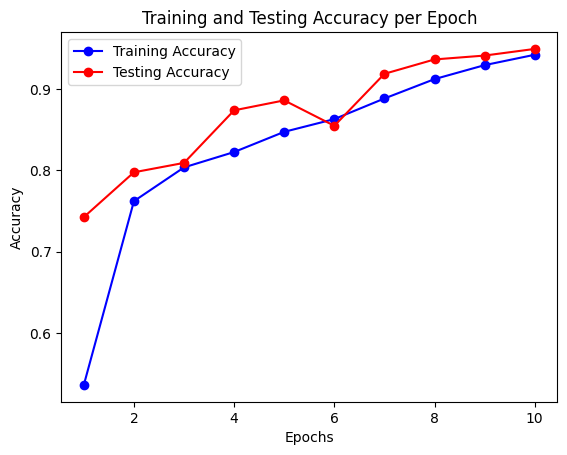

In [27]:
plot_accuracy_per_epoch(cnn_gru_history)